# Automated LEGO sorter belt

## Introduction

Our project aims to solve a common problem when playing with LEGO: classification. To address this issue, we have developed a belt system that uses computer vision and mechanical components to classify LEGO pieces according to their size, shape, and color. The system consists of two main parts: the computer vision component, which uses techniques such as Kalman filtering, contour detection, and deep learning to classify the LEGO pieces; and the mechanical component, which includes a belt, exit gates, and motors to transport and sort the LEGO pieces into their respective categories. One of the main features of our project is its flexibility: users can choose which attributes (size, shape, color) to classify the LEGO pieces by, adjust the speed of the belt, and calculate the velocity of the belt to time the operation of the exit gate motors. By automating the classification of LEGO pieces, our project makes it easier and more efficient to organize and play with LEGO.

## Belt structure

The belt system in our project consists of four main parts: the camera system, the belt base, the motor for belt, and the exiting gates.

For the camera system, we use a phone camera mounted on a selfie stick and fixed at the beginning of the belt. 

The belt base is made of two shaped aluminum pieces that create a long flat surface for the belt to slide on easily. These aluminum pieces also serve as the main base for mounting the motor and the exiting gates. At the head and tail of the belt, there are two wheels that scroll the belt surface. 

The motor is placed beside the belt and connected to the wheel at the head of the belt. When the motor rotates, it also rotates the wheel and scrolls the belt surface. 

At each exiting gate, there is a servo that kicks the LEGO piece off if it is at the right gate and has approached that gate.

## Method and result

### LEGO detection

Firstly, let's load the sample video for demonstration purpose. 

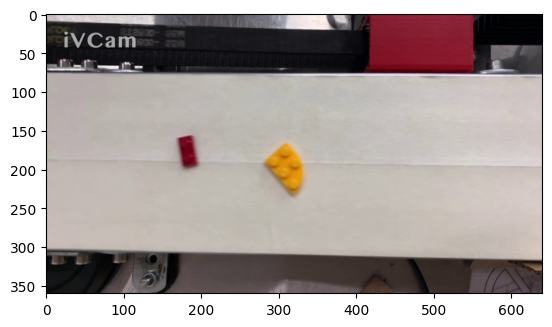

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

video_path = "./data/speed_high.mp4"
cap = cv.VideoCapture(video_path)
cap.set(cv.CAP_PROP_POS_MSEC, 15000)
ret, img = cap.read()
plt.imshow(img[:,:,::-1])
plt.show()

Next, we will select our Region of Interest to remove unnecessary noise. We will keep only the belt area.

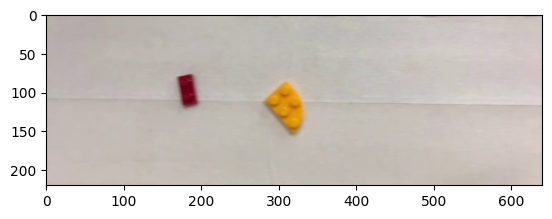

In [2]:
def get_roi(img):
    width = img.shape[1]
    height = img.shape[0]
    roi_height = 100
    ret = img[(height>>1)- roi_height:(height>>1)+roi_height + 20 , 0:width]

    return ret

img_roi = get_roi(img)
plt.imshow(img_roi[:,:,::-1])
plt.show()

After that, we want to identify the LEGO piece. Because the belt is always white,
we threshold the image to isolate the LEGO piece out from the background

Text(0.5, 1.0, 'Threshold image')

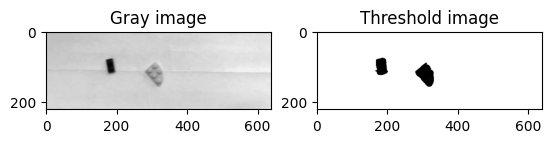

In [3]:
img_gray = cv.cvtColor(img_roi, cv.COLOR_BGR2GRAY)
img_gray = cv.GaussianBlur(img_gray, (5, 5), 0)
ret, thresh = cv.threshold(img_gray, 170, 255, 0)
plt.subplot(121); plt.imshow(img_gray, cmap='gray'); plt.title('Gray image')
plt.subplot(122); plt.imshow(thresh, cmap='gray'); plt.title('Threshold image')

To knows the location of each LEGO piece, we find the contours of the thresholded image.

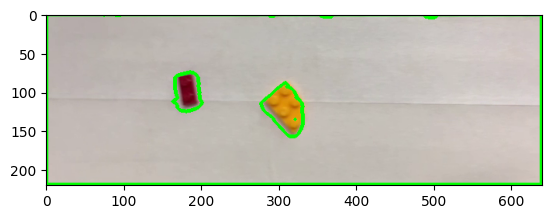

In [4]:
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
img_contour = cv.drawContours(img_roi.copy(), contours, -1, (0,255,0), 3)
plt.imshow(img_contour[:,:,::-1])
plt.show()


As you have seen, the contours are still a bit noisy and we have to filter them

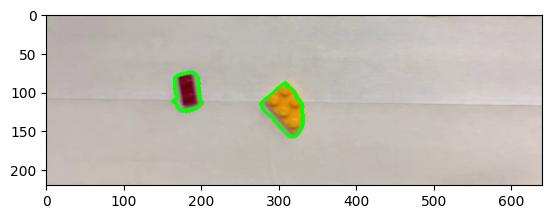

In [5]:
# We sort the contours by area and remove the small ones
contours = sorted(contours, key=lambda x: cv.contourArea(x), reverse=True)
bounding_boxes = []
contours_list = []
num_objects = 2 # Detect 2 objects at once

for i in range(len(contours)):
    if cv.contourArea(contours[i]) < 500: # eliminates small contours
        continue
    # We can see that the shadow is a big contour, so we can eliminate it by filtering out the big contours
    if cv.contourArea(contours[i]) > 50000: # eliminates unreasonably big contours
        continue
    if (len(contours[i]) > 8000): # this is a hack to eliminate the shadow
        continue
    contours_list.append(contours[i])
    if (len(contours_list) == num_objects): # we only need two bounding boxes for two objects (may increase more)
        break
img_contour = cv.drawContours(img_roi.copy(), contours_list, -1, (0,255,0), 3)
plt.imshow(img_contour[:,:,::-1])
plt.show()

Instead of drawing contour, we can draw bounding boxes that cover the objects

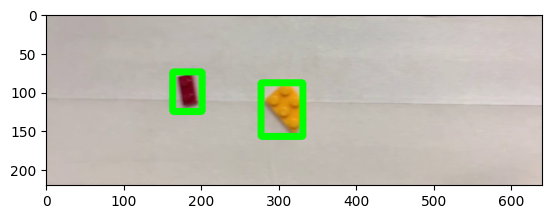

In [6]:
detected = img_roi.copy()
for i in range(len(contours_list)):
    bounding_boxes.append(((min(contours_list[i][:, :, 0])[0], min(contours_list[i][:, :, 1])[0]), 
              (max(contours_list[i][:, :, 0])[0], max(contours_list[i][:, :, 1])[0]))) # (x1, y1), (x2, y2)
    cv.rectangle(detected, bounding_boxes[i][0], bounding_boxes[i][1], (0, 255, 0), 7)
plt.imshow(detected[:,:,::-1])
plt.show()

### Speed tracking

To track the speed of the belt, we track the speed of the LEGO pieces using optical flow algorithm. 

Text(0.5, 1.0, 'Current frame')

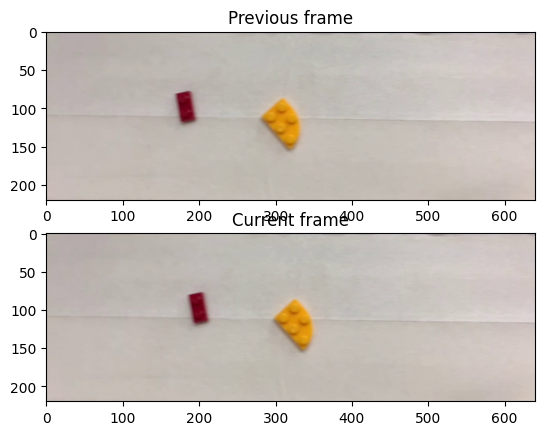

In [7]:
time_elapsed = 50
cap.set(cv.CAP_PROP_POS_MSEC, 15000 + time_elapsed)
img_next_roi = get_roi(cap.read()[1])
plt.subplot(211); plt.imshow(img_roi[:,:,::-1]); plt.title('Previous frame')
plt.subplot(212); plt.imshow(img_next_roi[:,:,::-1]); plt.title('Current frame')

Firstly, we need to find the corners of the previous frame to track the optical flow (optical flow works best for corners). We use Shi-tomasi corners detection

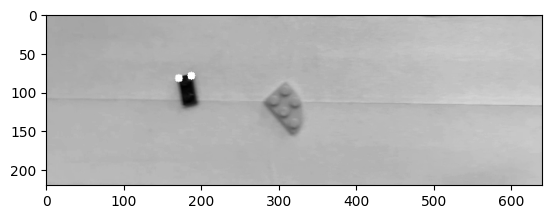

In [8]:
import numpy as np 

prev_img = cv.cvtColor(img_roi, cv.COLOR_BGR2GRAY)
cur_img = cv.cvtColor(img_next_roi, cv.COLOR_BGR2GRAY)
prev_bounding_boxes = bounding_boxes.copy()
mask = np.zeros_like(prev_img)
for box in prev_bounding_boxes:
    mask[box[0][1]:box[1][1], box[0][0]:box[1][0]] = 255
feature_params = dict( maxCorners = 5,
                    qualityLevel = 0.3,
                    minDistance = 10,
                    blockSize = 5 )
corners = cv.goodFeaturesToTrack(prev_img, mask = mask, **feature_params)
draw_corners = prev_img.copy()
for corner in corners:
    cv.circle(draw_corners, (int(corner[0][0]), int(corner[0][1])), 5, 255, -1)

plt.imshow(draw_corners, cmap='gray')
plt.show()

After getting the corner, we can use Lucas Kanade to find the next point in the motion (Corner tracking)

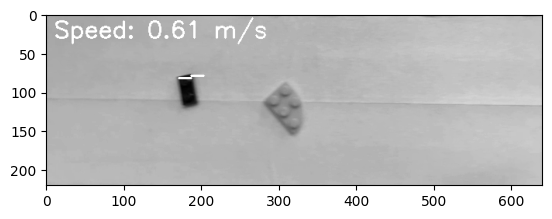

In [9]:
lk_params = dict( winSize  = (15,15),
                  maxLevel = 1,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.1))
next_corners, st, err = cv.calcOpticalFlowPyrLK(prev_img, cur_img, corners, None, **lk_params)
# if st == 0, no corresponding point is found
good_old = corners[st==1]
good_new = next_corners[st==1]
motion = prev_img.copy()
sum = 0
cnt = 0
for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = new.ravel()
    c, d = old.ravel()
    dist = np.linalg.norm(np.array([a, b]) - np.array([c, d]))
    # remove noise
    if (dist > 20):
        continue
    sum += dist
    cnt += 1
    prev_img = cv.line(motion, (int(a), int(b)), (int(c), int(d)), 255, 2)
avg = 0
# The length of the line is the average motion
if (cnt):
    avg = sum / cnt
    
fy = 5.5e-4 # focal length
D = 0.3 # distance from camera to legos
magic_number = fy/D # magic number to convert pixel to meter
speed = avg * magic_number / time_elapsed * 1000

cv.putText(motion, "Speed: {:.2f} m/s".format(speed), (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
plt.imshow(motion, cmap='gray')
plt.show()

However, in reality, the measured speed fluctuated a lot. To stabilize the speed to the exact value, we use Kalman Filter. When we plot the measured speed in histogram, it has the shape of normal distribution. This is the charasteristic that allow the usage of Kalman Filter. The speed is stabilized in the file kalman_filter.py. Please run main.py to see the demo



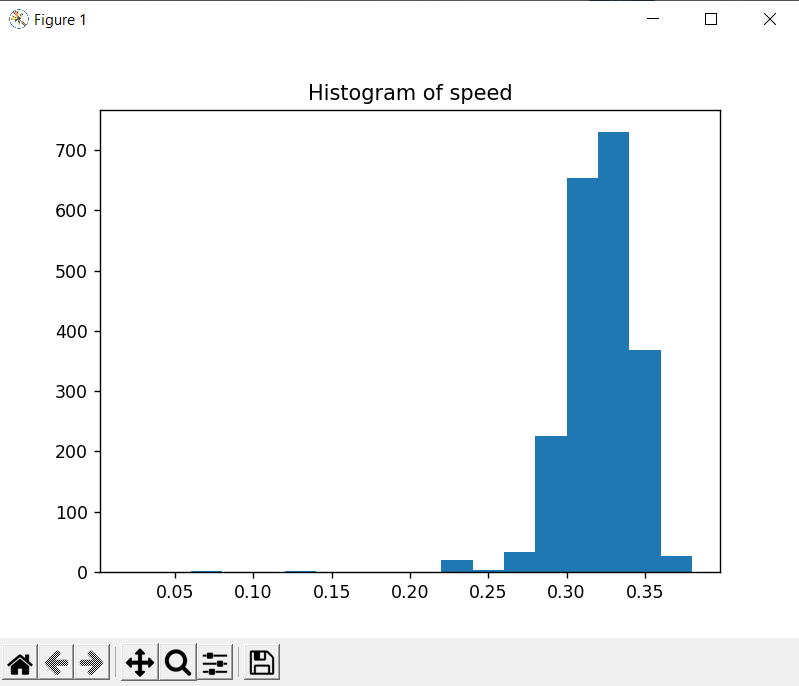
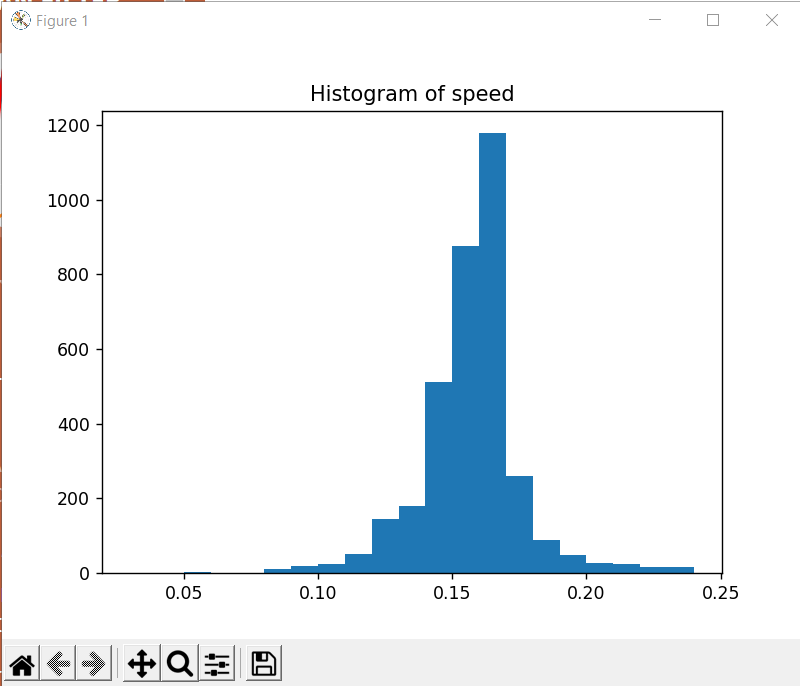

### Color

To get the color of the object, we simply calculate the average color of the object and compare it to the color code of red, green, yellow and black.

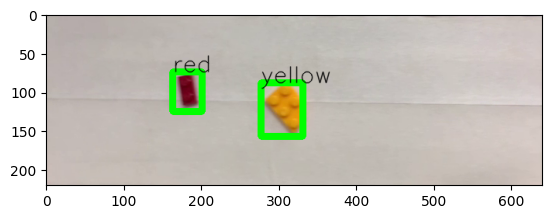

In [11]:
color_map = dict({
    'yellow': (83, 104, 118),
    'red': (55, 54, 134),
    'black': (50, 40, 42),
    'green':(53, 110, 24),
})


def detect_color(img, boxes):
    ret = []
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    for box in boxes:
        x1, y1 = box[0]
        x2, y2 = box[1]
        roi = img[y1:y2, x1:x2]
        roi_gray = img_gray[y1:y2, x1:x2]
        mask = cv.threshold(roi_gray, 160, 255, cv.THRESH_BINARY)[1]
        colors = roi[mask == 0]
        avg_color = np.mean(colors, axis=0)

        min_dist = 100000000
        fit_color = '?'
        for color in color_map:
            if (np.linalg.norm(avg_color - color_map[color]) < min_dist):
                min_dist = np.linalg.norm(avg_color - color_map[color])
                fit_color = color
        ret.append(fit_color)
    return ret

colors = detect_color(img_roi, bounding_boxes)
for (box, color) in zip(bounding_boxes, colors):
    cv.putText(detected, color, box[0], cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 1, cv.LINE_AA)
plt.imshow(detected[:,:,::-1])


### Size

#### Method

#### Result

### Shape

#### Method

#### Result

### Counting

#### Method

#### Result

### Servo gate

#### Method

#### Result